the dataset is available in two forms 
1. csv

2. sqlite

Here we will sqlite library which will be easy to fetch data

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#Importing the libarries

#%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
#import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\kajrolka\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\kajrolka\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Reading the data

In [2]:
# using sqlite table to read the data
con = sqlite3.connect('database.sqlite')

#Filtering only positive and negative reviews not taking into consideration reviews with score 3
# for this assignmnet we will consider only 5000 points

filtered_data = pd.read_sql_query("""SELECT * FROM reviews WHERE Score !=3 LIMIT 5000""",con)

filtered_data.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
#Function to differentiate point with score>3 and reviews with score < 3

def partition(x):
    if x > 3:
        return 1
    return 0

#Changing the reviews score based on above function

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data.Score = positiveNegative

filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
#NO of datapoints in filtered_data
filtered_data.shape

(5000, 10)

# EDA

### 15.2 Data Deduplication

It is obsereved that reviews data has many duplicate hence it is necessary to remove these entries

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [6]:
# Sorting the data according to productid

filtered_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort',na_position='last')

In [7]:
#Dropping dyuplicates

final = filtered_data.drop_duplicates(subset={'UserId','ProfileName','Time',"Text"},keep='first',inplace=False)

In [8]:
final.shape

(4986, 10)

In [9]:
#Checking to see how much % of data still remains

(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

# 15.12 Text preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
#Printing some random vallues

sent_0 = final.Text.values[0]
print(sent_0)
print('-'*50)

sent_1000 = final.Text.values[1000]
print(sent_1000)
print('-'*50)

sent_1500 = final.Text.values[1500]
print(sent_1500)
print('-'*50)

sent_4900 = final.Text.values[4900]
print(sent_4900)
print('-'*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
--------------------------------------------------
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
-------

In [14]:
# Removing urls from text

sent_0 = re.sub(r'http\S+','',sent_0)
sent_1000 = re.sub(r'http\S+','',sent_1000)
sent_1500 = re.sub(r'http\S+','',sent_1500)
sent_4900 = re.sub(r'http\S+','',sent_4900)

In [15]:
print(sent_0)
print('='*50)
print(sent_1000)
print('='*50)
print(sent_1500)
print('='*50)
print(sent_4900)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, 

In [16]:
#Removing all xml tags

from bs4 import BeautifulSoup


In [17]:
soup = BeautifulSoup(sent_0, 'lxml')
sent_0 = text = soup.get_text()
print(text)
print('='*50)

soup = BeautifulSoup(sent_1000, 'lxml')
sent_1000 = text = soup.get_text()
print(text)
print('='*50)

soup = BeautifulSoup(sent_1500, 'lxml')
sent_1500 = text = soup.get_text()
print(text)
print('='*50)

soup = BeautifulSoup(sent_4900, 'lxml')
sent_4900 = text = soup.get_text()
print(text)
print('='*50)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [18]:
#Converting specific phrases in its general form

def decontract(phrase):
    
    phrase = re.sub(r"won\'t","will not",phrase)
    phrase = re.sub(r"can\'t","will not",phrase)
    phrase = re.sub(r"n't"," not",phrase)
    phrase = re.sub(r"\'re"," are",phrase)
    phrase = re.sub(r"\'s"," is",phrase)
    phrase = re.sub(r"\'d"," would",phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"'t", " not", phrase)
    phrase = re.sub(r"'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_15002 = sent_1500

In [20]:
sent_15002 = decontract(sent_15002)

In [21]:
sent_15002

'Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh yeah, chocolate chip coo

In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip() #here strip is used to rmove heading and trailing spaces if any no has it
print(sent_0)

Why is this $[...] when the same product is available for $[...] here? />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [23]:
#removing special character

sent_0 = re.sub(r'[^A-Za-z0-9]+', '', sent_0)
print(sent_0)

WhyisthiswhenthesameproductisavailableforhereTheVictorandtrapsareunrealofcoursetotalflygenocidePrettystinkybutonlyrightnearby


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
#Combining all above codes

preprocessed_reviews = [] #it will contain text for every review which is preprocessed completely
from tqdm import tqdm  #For keeping progress of for loop

for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+" , "" , sentence) #to remove all urls in text reviews
    sentence = BeautifulSoup(sentence, 'lxml').get_text() #to remove all html-xml tags
    sentence = decontract(sentence) #to rplace all phrases like can't to can not etc.
    sentence = re.sub(r'\S*\d\S*', "",sentence).strip() #to remove all no fields from sentence
    sentence = re.sub(r'[^A-Za-z0-9]+'," ",sentence) #to remove all special char like punctuations or #$ etc from text and here space is given because space also is treated as special character in this case and is is getting removed and hence we need to add space between words
    #To remove all words that are present stpowords above from text review
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in  stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|█████████████████████████████████████| 4986/4986 [00:09<00:00, 507.25it/s]


In [26]:
preprocessed_reviews[0:5]

['product available victor traps unreal course total fly genocide pretty stinky right nearby',
 'used victor fly bait seasons ca not beat great product',
 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'glad cocker standard poodle puppy loves stuff trust brand superior nutrition compare labels previous feed pedigree mostly corn little dude healthy happy high energy glossy coat also superior nutrition produces smaller compact stools']

## Now above data is ready to go through various word2vec techniques

# Bag of Words

In [27]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


# Bi grams and n-grams

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


# TF -TDF

In [47]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


# Word2Vec

In [29]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [30]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('satisfying', 0.9971970915794373), ('alternative', 0.9970871210098267), ('feel', 0.9968729615211487), ('crisp', 0.996833860874176), ('soft', 0.9967215061187744), ('flavorful', 0.996661365032196), ('amazing', 0.9966186881065369), ('yummy', 0.9965595006942749), ('snack', 0.996551513671875), ('unique', 0.9965505599975586)]
[('type', 0.9994332790374756), ('oh', 0.9994328022003174), ('peanuts', 0.9994251728057861), ('wow', 0.9994124174118042), ('enjoyed', 0.9994006156921387), ('varieties', 0.9994001388549805), ('gourmet', 0.9993842840194702), ('simply', 0.9993759989738464), ('popcorn', 0.9993724822998047), ('yet', 0.9993689656257629)]


In [42]:
print(type(w2v_model))

<class 'gensim.models.word2vec.Word2Vec'>


In [31]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


In [45]:
w2v_vector = w2v_model.fit_transform(preprocessed_reviews)

AttributeError: 'Word2Vec' object has no attribute 'fit_transform'

# TSNE on Bagof words

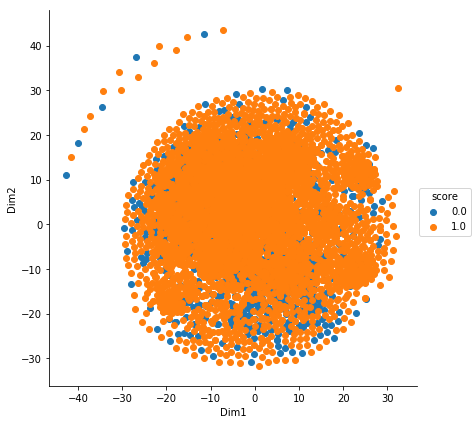

In [32]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
from sklearn.manifold import TSNE


model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter = 500)

tsne_data = model.fit_transform(final_counts.toarray())

#Creating a new data frame which help in plotting data points

tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','score'))

#plotting the TSNE result dataframe
sns.FacetGrid(tsne_df, hue='score', size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

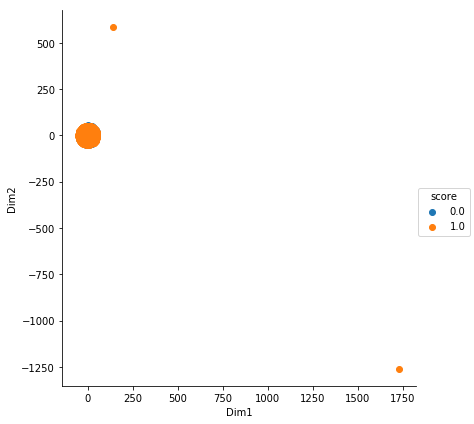

In [48]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter = 500)

tsne_data = model.fit_transform(final_tf_idf.toarray())

#Creating a new data frame which help in plotting data points

tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','score'))

#plotting the TSNE result dataframe
sns.FacetGrid(tsne_df, hue='score', size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()